테스트 해볼 것  
https://flonelin.wordpress.com/2019/12/14/regularization-in-deep-learning/  


activation - gap - bn - dropout  
activation - bn - dropout - gap

### Import module

In [1]:
from glob import glob
import os, sys
from os.path import join, dirname

import datetime, time
import csv
from glob import glob
import chardet
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler, MinMaxScaler

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, SimpleRNN, LSTM, GRU, Reshape, RepeatVector, Conv2DTranspose, Conv1D, Conv1DTranspose, ConvLSTM2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, Bidirectional, TimeDistributed,  Attention, BatchNormalization, GlobalAveragePooling1D, Dropout, GlobalMaxPool1D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG

import imblearn

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
device_lib.list_local_devices()

2.3.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1939572040513638982,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18155261465793276349
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3129973147
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17249188117991423719
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17510258188163265145
 physical_device_desc: "device: XLA_GPU device"]

### Global Parameter

In [2]:
num_classes = 7                           # {"0" : "Playing", "1" : "Talking", "2" : "Petting", "3" : "TV / Radio", "4" : "Eating / Cooking", "5" : "Moved It", "6" : "None of the above", "7" : "Other"}
time_offset = 10                           # 5초 단위 window: 50, 10초 단위 window: 90, 15초 단위 window: 128
window_size = 50
overlap_ratio = 0.5
bi_class = 6                              # Binary Classification (1 : Playing or not, 2 : Talking or not, 3 : Petting or not, 4: TV / Radio or not, 5 : Eating / Cooking or not, 6 : Moved It or not)
cross_val = 0
rand_st=2
mode = 0                                 # Split data {0: Didn't split, 1: US only, 2: Korea only, 3: train with US and test with Korea 4: train with Korea and test with US}

### Load Data

In [3]:
data_fname = '../Data/Preprocessed(new)/preprocessed_data(New collar_2).csv'

### Preprocess Data

In [4]:
data = pd.read_csv(data_fname)
data = data.fillna(0)

In [5]:
iaq = data['iaq']
iaq_cat = []

for num in iaq:
    if num < 50 and num >=0:
        iaq_cat.append('Good')
    elif num >= 50 and num < 100:
        iaq_cat.append('Average')
    elif num >= 100 and num < 150:
        iaq_cat.append('Little bad')
    elif num >= 150 and num < 200:
        iaq_cat.append('Bad')
    elif num >= 200 and num < 300:
        iaq_cat.append('Worse')
    elif num >= 300 and num <= 500:
        iaq_cat.append('Very bad')
    else:
        print(num)
data['iaq_cat'] = iaq_cat

In [6]:
data = pd.concat([data,pd.get_dummies(data['sound category'])],axis=1)         # Onehot encode sound category
data = pd.concat([data,pd.get_dummies(data['orientation_cat'])],axis=1)        # Onehot encode orientation category
data = pd.concat([data,pd.get_dummies(data['iaq_cat'])],axis=1)                # Onehot encode iaq category

In [7]:
# Create rowID list
rowID_list = np.array(data['RowID'].drop_duplicates())
data = data.to_records(index=False)

In [8]:
# Normalize Data

scaler = StandardScaler()

# data['pressure'] = scaler.fit_transform(data['pressure'].reshape(-1,1)).reshape(-1)
data['gasResistance'] = scaler.fit_transform(data['gasResistance'].reshape(-1,1)).reshape(-1)
data['staticIaq'] = scaler.fit_transform(data['staticIaq'].reshape(-1,1)).reshape(-1)
data['co2Equivalent'] = scaler.fit_transform(data['co2Equivalent'].reshape(-1,1)).reshape(-1)
data['breathVocEquivalent'] = scaler.fit_transform(data['breathVocEquivalent'].reshape(-1,1)).reshape(-1)
data['audioLevel'] = scaler.fit_transform(data['audioLevel'].reshape(-1,1)).reshape(-1)
data['rawTemp'] = scaler.fit_transform(data['rawTemp'].reshape(-1,1)).reshape(-1)
data['rawHumidity'] = scaler.fit_transform(data['rawHumidity'].reshape(-1,1)).reshape(-1)
data['pressure'] = scaler.fit_transform(data['pressure'].reshape(-1,1)).reshape(-1)

In [9]:
# Split US and Korea
us_rowIDs = []
korea_rowIDs = []

if mode != 0:
    for rowid in rowID_list:
    #     print(rowid, rowid[0])
        if rowid[0] == '1':
            korea_rowIDs.append(rowid)
        else:
            us_rowIDs.append(rowid)

In [10]:
# feature_col_name = ['accX', 'accY', 'accZ', 'chord', 'orientation', 'ir', 'full', 'iaq', 'iaqAccuracy', 'rawTemp',
#                     'pressure', 'rawHumidity', 'gasResistance', 'compGasAccuracy', 'gasPercentageAccuracy', 'temperature', 
#                     'humidity', 'staticIaq', 'statIaqAccuracy', 'co2Equivalent', 'co2Accuracy', 'breathVocEquivalent', 
#                     'breathVocAccuracy', 'audioLevel', 'Loud', 'Moderate', 'Quiet']
feature_col_name = ['accX', 'accY', 'accZ', 'arc', 'full', 'iaq', 'rawTemp',
                    'pressure', 'rawHumidity', 'gasResistance', 'staticIaq', 'co2Equivalent', 'breathVocEquivalent', 
                    'audioLevel', 'Loud', 'Moderate', 'Quiet', 'Landscape Left Back', 'Landscape Left Front', 'Landscape Right Back',
                    'Landscape Right Front', 'Portrait Down Back', 'Portrait Down Front', 'Portrait Up Back', 
                    'Portrait Up Front', 'Average', 'Bad', 'Good', 'Little bad', 'Very bad', 'Worse']
target_col_name = ['Modality_cat']

In [11]:
feature_num = len(feature_col_name)

In [12]:
X = []
us_X = []
korea_X = []

Y = []
us_Y = []
korea_Y = []


if mode != 0:
    for rowID in us_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        us_X.append(feature)
        us_Y.append(target)
    
    for rowID in korea_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        korea_X.append(feature)
        korea_Y.append(target)

else:
    for rowID in rowID_list:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        X.append(feature)
        Y.append(target)

In [13]:
if bi_class != 0:
    #Transit multi classification to binary classification
    if mode != 0:
        for idx in range(len(us_Y)):
            if us_Y[idx] == bi_class-1:
                us_Y[idx]=1
            else:
                us_Y[idx]=0
                
        for idx in range(len(korea_Y)):
            if korea_Y[idx] == bi_class-1:
                korea_Y[idx]=1
            else:
                korea_Y[idx]=0
    else:
        for idx in range(len(Y)):
            if Y[idx] == bi_class-1:
                Y[idx]=1
            else:
                Y[idx]=0

In [14]:
def X_preprocess(X, window_size, overlap_ratio):
    #Transform data shape using the set time window
    processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size
        
        if len(tmp_X)%int(window_size*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)-1):
                tmp.append(tmp_X[int(start_row):int(end_row)])
                start_row += (window_size*overlap_ratio)
                end_row += (window_size*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[-window_size:])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
                    break
                else:
                    
                    tmp.append(tmp_X[int(start_row):int(end_row)])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
        processed_X.append(tmp)
        
    return processed_X

In [15]:
if mode != 0:
    us_X = X_preprocess(us_X, window_size, overlap_ratio)        ### preprocess with input shape
    korea_X = X_preprocess(korea_X, window_size, overlap_ratio)
    if bi_class == 0:
        ### onehot encode Y
        us_Y = np.eye(num_classes)[us_Y]
        korea_Y = np.eye(num_classes)[korea_Y]
    else: 
        us_Y = np.eye(2)[us_Y]
        korea_Y = np.eye(2)[korea_Y]

else:    
    X = X_preprocess(X, window_size, overlap_ratio)        ### preprocess with input shape
    if bi_class == 0:
        ### onehot encode Y
        Y = np.eye(num_classes)[Y]
    else: Y = np.eye(2)[Y]

In [16]:
# Subsample X Data size

def subsample(X, min_us_len, min_korea_len):
    sampled_X = []
    addon = 0
    
    if min_korea_len > min_us_len:
        if np.array(X).shape[1] == min_us_len:
            return X
        else:
            interval = min_korea_len / min_us_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_us_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

                sampled_X.append(temp_X)
            
    else:
        if np.array(X).shape[1] == min_korea_len:
            return X
        else:
            interval = min_us_len / min_korea_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_korea_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

            sampled_X.append(temp_X)
                    
    return sampled_X

In [17]:
# Fit to minimum length

min_len = 99999999
min_us_len = 99999999
min_korea_len = 99999999
min_X = []
min_us_X = []
min_korea_X = []

if mode == 0:
#     print('Start mode 0\n')
    for x in X:
        if len(x) < min_len:
            min_len = len(x)
#     print(min_len)

    for x in X:
        min_X.append(x[:min_len])

else:
    for x in us_X:
        if len(x) < min_us_len:
            min_us_len = len(x)
            
    for x in korea_X:
        if len(x) < min_korea_len:
            min_korea_len = len(x)
            
    if mode == 1:
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    elif mode == 2:
        min_korea_len = 60
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    else:
        if min_korea_len < min_us_len:
            min_len = min_korea_len
        else: min_len = min_us_len

        for x in us_X:
            min_us_X.append(x[:min_len])

        for x in korea_X:
            min_korea_X.append(x[:min_len])

In [18]:
# Drop duplicate

if bi_class != 0:
    
    target_list = []
    us_target_list = []
    korea_target_list = []
    del_list = []
    us_del_list = []
    korea_del_list = []
    
    if mode == 0:
        for i in range(len(Y)):
            if Y[i][1] == 1:
                target_list.append(i)

        for i in target_list:
            for j in range(len(min_X)):
                if j in target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_X[i]), np.array(min_X[j])):
                        if j not in del_list:
                            del_list.append(j)
        X = []
        Target = []

        for i in range(len(Y)):
            if i not in del_list:
                X.append(min_X[i])
                Target.append(Y[i])
                
    else:
        for i in range(len(us_Y)):
            if us_Y[i][1] == 1:
                us_target_list.append(i)

        for i in us_target_list:
            for j in range(len(min_us_X)):
                if j in us_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_us_X[i]), np.array(min_us_X[j])):
                        if j not in us_del_list:
                            us_del_list.append(j)
                            
        for i in range(len(korea_Y)):
            if korea_Y[i][1] == 1:
                korea_target_list.append(i)

        for i in korea_target_list:
            for j in range(len(min_korea_X)):
                if j in korea_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_korea_X[i]), np.array(min_korea_X[j])):
                        if j not in korea_del_list:
                            korea_del_list.append(j)
        
        us_X = []
        us_Target = []
        korea_X = []
        korea_Target = []

        for i in range(len(us_Y)):
            if i not in us_del_list:
                us_X.append(min_us_X[i])
                us_Target.append(us_Y[i])
                
        for i in range(len(korea_Y)):
            if i not in korea_del_list:
                korea_X.append(min_korea_X[i])
                korea_Target.append(korea_Y[i])

else:
    target_list = []
    us_target_list = []
    korea_target_list = []
    del_list = []
    us_del_list = []
    korea_del_list = []
    
    if mode == 0:
        X = min_X
        Target = Y

    else:
        for i in range(len(us_Y)):
            if us_Y[i][1] == 1:
                us_target_list.append(i)

        for i in us_target_list:
            for j in range(len(min_us_X)):
                if j in us_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_us_X[i]), np.array(min_us_X[j])):
                        if j not in us_del_list:
                            us_del_list.append(j)

        for i in range(len(korea_Y)):
            if korea_Y[i][1] == 1:
                korea_target_list.append(i)

        for i in korea_target_list:
            for j in range(len(min_korea_X)):
                if j in korea_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_korea_X[i]), np.array(min_korea_X[j])):
                        if j not in korea_del_list:
                            korea_del_list.append(j)

        us_X = []
        us_Target = []
        korea_X = []
        korea_Target = []

        for i in range(len(us_Y)):
            if i not in us_del_list:
                us_X.append(min_us_X[i])
                us_Target.append(us_Y[i])

        for i in range(len(korea_Y)):
            if i not in korea_del_list:
                korea_X.append(min_korea_X[i])
                korea_Target.append(korea_Y[i])

In [19]:
if mode == 0:
#     X = subsample(X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Target, test_size=0.2)
    
elif mode == 1:
    us_X = subsample(us_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(us_X, us_Target, test_size=0.2)

elif mode == 2:
    korea_X = subsample(korea_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(korea_X, korea_Target, test_size=0.2)

elif mode == 3:
    X_train = subsample(us_X, min_us_len, min_korea_len)
    X_test = subsample(korea_X, min_us_len, min_korea_len)
    Y_train = us_Target 
    Y_test = korea_Target

else:
    X_train = subsample(korea_X, min_us_len, min_korea_len)
    X_test = subsample(us_X, min_us_len, min_korea_len)
    Y_train = korea_Target
    Y_test = us_Target 

-----------------------------------------
### End Setup, separate model sections
-----------------------------------------

### Generative Replay #1 - GAN
- https://keras.io/examples/generative/dcgan_overriding_train_step/
- https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889
- https://www.tensorflow.org/tutorials/generative/dcgan
- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
- https://www.kaggle.com/function9/bidirectional-lstm-gan-music-generation
- https://wiki.pathmind.com/generative-adversarial-network-gan
- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=chunjein&logNo=221589624838  
    
http://www.smartdesignlab.org/DL/%EC%8B%A0%EA%B8%B0%EC%88%A0/GAN_keras.html - 참고 필요  
http://www.smartdesignlab.org/DL/GAN_tf2.html  
https://deep-eye.tistory.com/63  
https://velog.io/@hyebbly/Deep-Learning-Loss-%EC%A0%95%EB%A6%AC-1-GAN-loss

In [20]:
### Data Setup ###

#Rebalance the data
if bi_class == 0:
    sm = imblearn.over_sampling.SMOTE()
    X_shape = np.array(X_train).shape
    Y_shape = np.array(Y_train).shape
    new_X_train = np.array(X_train).reshape(X_shape[0], X_shape[1]*X_shape[2]*X_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], X_shape[1], X_shape[2], X_shape[3]])
    Y_train = Y_train.reshape(temp[0], Y_shape[1])

else:
    sm = imblearn.over_sampling.SMOTE()         # random state do not set
    origin_shape = np.array(X_train).shape
    new_X_train = np.array(X_train).reshape(origin_shape[0], origin_shape[1]*origin_shape[2]*origin_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], origin_shape[1], origin_shape[2], origin_shape[3]])
    Y_train = np.eye(2)[Y_train.reshape(temp[0])]

C:\Users\sckim\.conda\envs\grad\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [21]:
X_train.shape

(492, 276, 50, 31)

In [22]:
def make_generator_model(input_shape, feature_num=feature_num):
    
    gen = Dense(feature_num, use_bias=False, name='gen_Dense1')(input_shape)
    
#     gen = BatchNormalization(momentum=0.8, name='gen_BM1')(gen)
    gen = RepeatVector(276)(gen)
    gen = layers.LeakyReLU(alpha=0.2, name='gen_activ1')(gen)
    gen = GRU(units=50, activation='tanh', recurrent_activation='sigmoid',return_sequences=True, name='gen_rnn1')(gen)
#     gen = BatchNormalization(momentum=0.8, name='gen_BM2')(gen)
    gen = tf.expand_dims(gen, -1)
#     gen = Reshape((576,24,1), name='gen_reshape1')(gen)
    gen_output = Conv2DTranspose(feature_num, 1, padding="same", activation='relu', name='gen_conv1')(gen)
    
    model = Model(inputs=input_shape, outputs=gen_output, name='Generator')          
    
    return model

In [23]:
# 노이즈 만들어서 generator에 넣은 후 나오는 이미지 출력 (확인용)

g_input_shape = keras.Input(shape=(31,))
generator = make_generator_model(g_input_shape)
generator.summary()

noise = tf.random.normal([1, 31])
generated_image = generator(noise, training=False)

np.array(generated_image[:, :, :, :]).shape

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
gen_Dense1 (Dense)           (None, 31)                961       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 276, 31)           0         
_________________________________________________________________
gen_activ1 (LeakyReLU)       (None, 276, 31)           0         
_________________________________________________________________
gen_rnn1 (GRU)               (None, 276, 50)           12450     
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 276, 50, 1)]      0         
_________________________________________________________________
gen_conv1 (Conv2DTranspose)  (None, 276, 50, 31)       62

(1, 276, 50, 31)

https://velog.io/@byu0hyun/%EB%94%A5%EB%9F%AC%EB%8B%9D-CNN-Conv2D-Layer

In [24]:
def make_discriminator_model(input_shape, RNN_unit=200, feature_num = feature_num):
#     print(input_shape.shape[0])
    rnn_input = Reshape((input_shape.shape[1], input_shape.shape[2]*input_shape.shape[3]), name='reshape1')(input_shape)
    disc = GRU(units=RNN_unit, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, name='disc_rnn1')(rnn_input)
#     disc = LSTM(units=RNN_unit, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, name='disc_rnn2')(disc)
#     disc = LSTM(units=RNN_unit, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, kernel_regularizer='l1', name='disc_rnn2')(disc)
    disc = BatchNormalization(name='disc_BM1')(disc)
    disc = Conv1D(64, 8, padding='same', name='disc_conv1')(disc)
#     disc = Conv1D(128, 8, padding='same', name='disc_conv2')(disc)
#     disc = GlobalMaxPool1D()(disc)
    disc = GlobalAveragePooling1D()(disc)
    disc = BatchNormalization(name='disc_BM2')(disc)
    disc = layers.LeakyReLU(alpha=0.2, name='disc_activ1')(disc)
#     disc = Dropout(0.2)(disc)
    

    return disc

In [25]:
def make_disc_output(discriminator):

    discriminator_output = Dense(1, activation='sigmoid')(discriminator)
    
    return discriminator_output

In [26]:
# image를 discriminator에 넣었을 때 판별값이 나옴 (예시. 확인용)
input_shape = np.array(X_train[0]).shape
feature_input = keras.Input(shape=input_shape)

discriminator = Model(inputs=feature_input, outputs=make_disc_output(make_discriminator_model(feature_input)), name='Discriminator')
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 276, 50, 31)]     0         
_________________________________________________________________
reshape1 (Reshape)           (None, 276, 1550)         0         
_________________________________________________________________
disc_rnn1 (GRU)              (None, 276, 200)          1051200   
_________________________________________________________________
disc_BM1 (BatchNormalization (None, 276, 200)          800       
_________________________________________________________________
disc_conv1 (Conv1D)          (None, 276, 64)           102464    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
disc_BM2 (BatchNormalization (None, 64)              

In [27]:
optimizer = Adam(0.0005, 0.5)

generator.compile(loss='binary_crossentropy', optimizer=optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [28]:
# Combined Model
# 랜덤으로 만든 이미지로부터 학습해서 새로운 이미지를 만들어내는 generator의 데이터를 discriminator가 분류. 

g_input_shape = keras.Input(shape=(31,))
# noise = tf.random.normal([64, feature_num])

fake_input = generator(g_input_shape)


# 모델을 합쳐서 학습하기 때문에 발란스 때문에 discriminator는 학습을 꺼둠. 우리는 generator만 학습
discriminator.trainable = False

# discriminator에 이미지를 입력으로 넣어서 진짜이미지인지 가짜이미지인지 판별
valid = discriminator(fake_input)

# generator와 discriminator 모델 합침. (노이즈가 인풋으로 들어가서 판별결과가 아웃풋으로 나오게)
# discriminator를 속이도록 generator를 학습
combined = Model(g_input_shape, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
Generator (Functional)       (None, 276, 50, 31)       13473     
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 1154785   
Total params: 1,168,258
Trainable params: 13,473
Non-trainable params: 1,154,785
_________________________________________________________________


### Training GAN

In [29]:
# hyper parameter 설정 
EPOCHS = 500
noise_dim = feature_num
num_examples_to_generate = 16
BATCH_SIZE = 32

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train).transpose([0,1,2,3])).shuffle(len(X_train)).batch(BATCH_SIZE)

In [30]:
def train(dataset, epochs, batch_size=BATCH_SIZE):
    history = []
    for epoch in range(epochs):
        start = time.time()
        print ('Epoch {} '.format(epoch + 1))
        
        e_g_loss = 0
        e_d_loss = 0
        
        for data_batch in dataset:
#             train_step(data_batch)
        
#             # batch_size만큼 이미지와 라벨을 랜덤으로 뽑음
#             idx = np.random.randint(0, dataset.shape[0], batch_size)
#             inputs = dataset[idx]

            noise = tf.random.normal([len(data_batch), feature_num])
            valid = np.ones((len(data_batch), 1))
            fake = np.zeros((len(data_batch), 1))
    #         history = []

             # Sample noise 생성(batch_size만큼)
            noise = np.random.normal(0, 1, (len(data_batch), 31))

            # noise를 generator에 넣어서 fake image 이미지 생성
            gen_inputs = generator.predict(noise)

            # discriminator를 학습함. 진짜 이미지는 1이 나오게, 가짜 이미지는 0이 나오게
            # discriminator가 이미지를 판별한 값과 valid와 fake가 
            # 각각 같이 들어가서 binary_crossentropy으로 계산되어 업데이트함.
            d_loss_real = discriminator.train_on_batch(data_batch, valid)
            d_loss_fake = discriminator.train_on_batch(gen_inputs, fake)

            # real을 넣었을 때와 fake를 넣었을 때의 discriminator의 loss값과 accracy값의 평균을 구함.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            e_d_loss = d_loss

            # ---------------------
            #  Train Generator
            # ---------------------

            # noise 생성
    #         noise = np.random.normal(0, 1, (batch_size, feature_num))
            noise = tf.random.normal([len(data_batch), noise_dim])

            # noise가 들어가서 discriminator가 real image라고 판단하도록 generator를 학습
            g_loss = combined.train_on_batch(noise, valid)
            e_g_loss = g_loss

        history.append([e_d_loss, e_g_loss])
        print("D loss: %f, G loss: %f" % (d_loss, g_loss))
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Runtime: {} sec'.format(time.time()-start))
        
    # Display D_loss, G_loss
    
    fig, ax = plt.subplots(2, figsize = (10,10))
    ax[0].plot(list(zip(*history))[0], 'y', label='D_loss')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('loss')
    ax[0].set_title("D_loss")
    ax[0].legend(loc='upper left')
    
    
    ax[1].plot(list(zip(*history))[1], 'b', label='G_loss')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('loss')
    ax[1].set_title("G_loss")
    ax[1].legend(loc='upper left')
    
#     fig, loss_ax = plt.subplots()

#     acc_ax = loss_ax.twinx()

#     loss_ax.plot(list(zip(*history))[0], 'y', label='D_loss')

#     acc_ax.plot(list(zip(*history))[1], 'b', label='G_loss')

#     loss_ax.set_xlabel('epoch')
#     loss_ax.set_ylabel('D_loss')
#     acc_ax.set_ylabel('G_loss')

#     loss_ax.legend(loc='upper left')
#     acc_ax.legend(loc='upper right')

    plt.show()

Epoch 1 
D loss: 0.617651, G loss: 0.664708
Runtime: 18.723504304885864 sec
Epoch 2 
D loss: 0.605815, G loss: 0.571508
Runtime: 7.575970411300659 sec
Epoch 3 
D loss: 0.592991, G loss: 0.539836
Runtime: 7.670622825622559 sec
Epoch 4 
D loss: 0.626960, G loss: 0.347163
Runtime: 7.703887701034546 sec
Epoch 5 
D loss: 0.581301, G loss: 0.201936
Runtime: 7.592510223388672 sec
Epoch 6 
D loss: 0.593182, G loss: 0.140257
Runtime: 7.5500876903533936 sec
Epoch 7 
D loss: 0.583063, G loss: 0.153010
Runtime: 7.8887269496917725 sec
Epoch 8 
D loss: 0.655201, G loss: 0.108337
Runtime: 7.615651607513428 sec
Epoch 9 
D loss: 0.585211, G loss: 0.227518
Runtime: 7.499051809310913 sec
Epoch 10 
D loss: 0.604373, G loss: 0.127380
Runtime: 7.637843132019043 sec
Epoch 11 
D loss: 0.559025, G loss: 0.013072
Runtime: 7.722620487213135 sec
Epoch 12 
D loss: 0.636879, G loss: 0.034710
Runtime: 8.273183584213257 sec
Epoch 13 
D loss: 0.577415, G loss: 0.015018
Runtime: 7.599886417388916 sec
Epoch 14 
D loss: 

D loss: 0.227909, G loss: 0.000000
Runtime: 8.048150062561035 sec
Epoch 110 
D loss: 0.186807, G loss: 0.000000
Runtime: 7.999083518981934 sec
Epoch 111 
D loss: 0.099150, G loss: 0.000000
Runtime: 7.7778098583221436 sec
Epoch 112 
D loss: 0.333960, G loss: 0.000000
Runtime: 7.538572788238525 sec
Epoch 113 
D loss: 0.469545, G loss: 0.000000
Runtime: 7.659038782119751 sec
Epoch 114 
D loss: 0.142619, G loss: 0.000000
Runtime: 7.617876291275024 sec
Epoch 115 
D loss: 0.263973, G loss: 0.000000
Runtime: 7.535585165023804 sec
Epoch 116 
D loss: 0.235538, G loss: 0.000000
Runtime: 7.7282044887542725 sec
Epoch 117 
D loss: 0.521885, G loss: 0.000000
Runtime: 7.63857102394104 sec
Epoch 118 
D loss: 0.216799, G loss: 0.000000
Runtime: 7.68387770652771 sec
Epoch 119 
D loss: 0.219862, G loss: 0.000000
Runtime: 7.532737970352173 sec
Epoch 120 
D loss: 0.149254, G loss: 0.000000
Runtime: 7.688509464263916 sec
Epoch 121 
D loss: 0.411836, G loss: 0.000000
Runtime: 7.765485763549805 sec
Epoch 122 

D loss: 0.070582, G loss: 0.000000
Runtime: 7.505725145339966 sec
Epoch 217 
D loss: 0.273299, G loss: 0.000000
Runtime: 7.547732591629028 sec
Epoch 218 
D loss: 0.027758, G loss: 0.000000
Runtime: 7.425504922866821 sec
Epoch 219 
D loss: 0.067864, G loss: 0.000000
Runtime: 7.411661148071289 sec
Epoch 220 
D loss: 0.113077, G loss: 0.000000
Runtime: 7.421828746795654 sec
Epoch 221 
D loss: 0.080700, G loss: 0.000000
Runtime: 7.62818717956543 sec
Epoch 222 
D loss: 0.107309, G loss: 0.000000
Runtime: 7.492060422897339 sec
Epoch 223 
D loss: 0.074309, G loss: 0.000000
Runtime: 7.362537622451782 sec
Epoch 224 
D loss: 0.169365, G loss: 0.000000
Runtime: 7.400204420089722 sec
Epoch 225 
D loss: 0.657096, G loss: 0.000000
Runtime: 7.5280373096466064 sec
Epoch 226 
D loss: 0.034568, G loss: 0.000000
Runtime: 7.447983264923096 sec
Epoch 227 
D loss: 0.080935, G loss: 0.000000
Runtime: 7.41758131980896 sec
Epoch 228 
D loss: 0.153310, G loss: 0.000000
Runtime: 7.626945495605469 sec
Epoch 229 


D loss: 0.169867, G loss: 0.000000
Runtime: 8.2286958694458 sec
Epoch 324 
D loss: 0.397370, G loss: 0.000000
Runtime: 8.22379446029663 sec
Epoch 325 
D loss: 0.386855, G loss: 0.000000
Runtime: 8.547491312026978 sec
Epoch 326 
D loss: 0.014555, G loss: 0.000000
Runtime: 8.786919832229614 sec
Epoch 327 
D loss: 0.021100, G loss: 0.000000
Runtime: 8.28653621673584 sec
Epoch 328 
D loss: 0.045257, G loss: 0.000000
Runtime: 8.516305923461914 sec
Epoch 329 
D loss: 0.035715, G loss: 0.000000
Runtime: 8.746442317962646 sec
Epoch 330 
D loss: 0.010803, G loss: 0.000000
Runtime: 8.677185297012329 sec
Epoch 331 
D loss: 0.007732, G loss: 0.000000
Runtime: 8.41763949394226 sec
Epoch 332 
D loss: 0.106150, G loss: 0.000000
Runtime: 8.395476579666138 sec
Epoch 333 
D loss: 0.015027, G loss: 0.000000
Runtime: 8.260476112365723 sec
Epoch 334 
D loss: 0.513366, G loss: 0.000000
Runtime: 8.287329196929932 sec
Epoch 335 
D loss: 0.070797, G loss: 0.000000
Runtime: 8.477478742599487 sec
Epoch 336 
D lo

D loss: 0.056233, G loss: 0.000000
Runtime: 8.079274415969849 sec
Epoch 431 
D loss: 0.054654, G loss: 0.000000
Runtime: 8.135852813720703 sec
Epoch 432 
D loss: 0.033158, G loss: 0.000000
Runtime: 8.197063207626343 sec
Epoch 433 
D loss: 0.034758, G loss: 0.000000
Runtime: 8.129900693893433 sec
Epoch 434 
D loss: 0.133804, G loss: 0.000000
Runtime: 8.139867305755615 sec
Epoch 435 
D loss: 0.173683, G loss: 0.000000
Runtime: 8.324730396270752 sec
Epoch 436 
D loss: 0.008210, G loss: 0.000000
Runtime: 8.205647230148315 sec
Epoch 437 
D loss: 0.007784, G loss: 0.000000
Runtime: 8.457895278930664 sec
Epoch 438 
D loss: 0.019174, G loss: 0.000000
Runtime: 8.46771788597107 sec
Epoch 439 
D loss: 0.027065, G loss: 0.000000
Runtime: 8.546318769454956 sec
Epoch 440 
D loss: 0.078935, G loss: 0.000000
Runtime: 8.485247135162354 sec
Epoch 441 
D loss: 0.012767, G loss: 0.000000
Runtime: 8.38861632347107 sec
Epoch 442 
D loss: 0.018856, G loss: 0.000000
Runtime: 8.455402612686157 sec
Epoch 443 
D

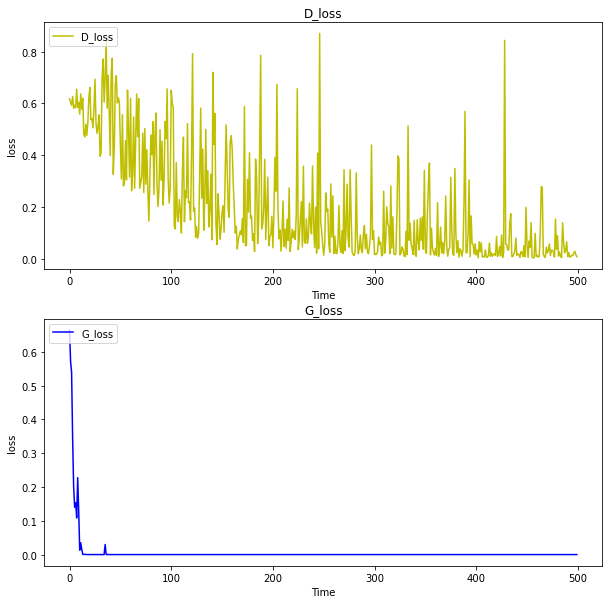

CPU times: total: 1h 11min 8s
Wall time: 1h 5min 17s


In [31]:
%%time
train(train_dataset, EPOCHS)

### Classification

In [32]:
def fc(discriminator, bi_class, num_classes):

#     den = Dense(64, activation='relu')(discriminator)
#     den = tf.keras.layers.LeakyReLU()(den)
    den = Dense(32)(discriminator)
    den = tf.keras.layers.LeakyReLU()(den)
    den = BatchNormalization()(den)
#     den = Dropout(0.5)(den)
#     den = Dense(16)(den)
#     den = tf.keras.layers.LeakyReLU()(den)
    
    
    if bi_class == 0:
        den = Dense(num_classes, activation='softmax')(den)
    else:
        den = Dense(2, activation='softmax')(den)
#     den = BatchNormalization()(den)
#     den = tf.keras.layers.LeakyReLU()(den)
#     den = Dense(7)(den)
#     den = BatchNormalization()(den)
#     out = tf.keras.activations.softmax(den)
    
    return den

In [33]:
disc = make_discriminator_model(feature_input)
full_model = Model(feature_input,fc(disc, bi_class, num_classes), name="Classification_model")
full_model.summary()

Model: "Classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 276, 50, 31)]     0         
_________________________________________________________________
reshape1 (Reshape)           (None, 276, 1550)         0         
_________________________________________________________________
disc_rnn1 (GRU)              (None, 276, 200)          1051200   
_________________________________________________________________
disc_BM1 (BatchNormalization (None, 276, 200)          800       
_________________________________________________________________
disc_conv1 (Conv1D)          (None, 276, 64)           102464    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
disc_BM2 (BatchNormalization (None, 64)       

In [34]:
for l1,l2 in zip(full_model.layers[:8], discriminator.layers[:8]):
    l1.set_weights(l2.get_weights())

In [35]:
for layer in full_model.layers[:8]:
    layer.trainable = False

In [36]:
if bi_class == 0:
    full_model.compile(optimizer=Adam(lr=0.05), loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.AUC(multi_label=True), tfa.metrics.F1Score(num_classes=num_classes)])
    hist = full_model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=np.array(Y_train).transpose([0,1]), batch_size=None, validation_split=0.2, epochs=1000)
else:
    full_model.compile(optimizer=Adam(lr=0.05), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC()])
    hist = full_model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=np.array(Y_train).transpose([0,1]), batch_size=None, validation_split=0.2, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 2s 152ms/step - loss: 0.8325 - accuracy: 0.5802 - auc: 0.5929 - val_loss: 0.0966 - val_accuracy: 0.9596 - val_auc: 0.9984
Epoch 2/1000
13/13 [==============================] - 1s 69ms/step - loss: 0.6666 - accuracy: 0.6539 - auc: 0.6815 - val_loss: 2.9995e-06 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 3/1000
13/13 [==============================] - 1s 67ms/step - loss: 0.6336 - accuracy: 0.6896 - auc: 0.7294 - val_loss: 5.7528e-07 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 4/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.6801 - accuracy: 0.6234 - auc: 0.6569 - val_loss: 7.0493e-04 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 5/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.6285 - accuracy: 0.6565 - auc: 0.7169 - val_loss: 4.5061e-04 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 6/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.6338 - accuracy: 0.6997 - auc: 

13/13 [==============================] - 1s 54ms/step - loss: 0.5646 - accuracy: 0.7099 - auc: 0.7846 - val_loss: 0.8961 - val_accuracy: 0.4343 - val_auc: 0.3382
Epoch 48/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.5618 - accuracy: 0.6921 - auc: 0.7861 - val_loss: 1.5531 - val_accuracy: 0.0707 - val_auc: 0.0301
Epoch 49/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.5662 - accuracy: 0.6896 - auc: 0.7779 - val_loss: 0.6364 - val_accuracy: 0.6566 - val_auc: 0.6863
Epoch 50/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.5468 - accuracy: 0.6972 - auc: 0.7950 - val_loss: 0.4303 - val_accuracy: 0.8384 - val_auc: 0.9163
Epoch 51/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.5731 - accuracy: 0.7201 - auc: 0.7734 - val_loss: 0.9741 - val_accuracy: 0.3939 - val_auc: 0.2936
Epoch 52/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.5581 - accuracy: 0.7125 - auc: 0.7876 - val_loss: 0.7961

Epoch 94/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.5048 - accuracy: 0.7379 - auc: 0.8312 - val_loss: 1.3048 - val_accuracy: 0.2626 - val_auc: 0.1702
Epoch 95/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.5126 - accuracy: 0.7405 - auc: 0.8283 - val_loss: 0.7988 - val_accuracy: 0.4343 - val_auc: 0.4803
Epoch 96/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.5155 - accuracy: 0.7074 - auc: 0.8219 - val_loss: 0.7279 - val_accuracy: 0.4848 - val_auc: 0.5730
Epoch 97/1000
13/13 [==============================] - 1s 67ms/step - loss: 0.4952 - accuracy: 0.7583 - auc: 0.8400 - val_loss: 1.6858 - val_accuracy: 0.0707 - val_auc: 0.0244
Epoch 98/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.5251 - accuracy: 0.7608 - auc: 0.8187 - val_loss: 1.2326 - val_accuracy: 0.3333 - val_auc: 0.1642
Epoch 99/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.5228 - accuracy: 0.7303 - auc: 0.8211 - va

13/13 [==============================] - 1s 64ms/step - loss: 0.5191 - accuracy: 0.7277 - auc: 0.8232 - val_loss: 0.9926 - val_accuracy: 0.4242 - val_auc: 0.3288
Epoch 141/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.5047 - accuracy: 0.7761 - auc: 0.8388 - val_loss: 1.3103 - val_accuracy: 0.2727 - val_auc: 0.1028
Epoch 142/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.4845 - accuracy: 0.7608 - auc: 0.8439 - val_loss: 0.8962 - val_accuracy: 0.4444 - val_auc: 0.4588
Epoch 143/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.5052 - accuracy: 0.7557 - auc: 0.8362 - val_loss: 0.3346 - val_accuracy: 0.8788 - val_auc: 0.9318
Epoch 144/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.5018 - accuracy: 0.7634 - auc: 0.8365 - val_loss: 0.6543 - val_accuracy: 0.5657 - val_auc: 0.6873
Epoch 145/1000
13/13 [==============================] - 1s 66ms/step - loss: 0.5003 - accuracy: 0.7430 - auc: 0.8335 - val_loss: 0

13/13 [==============================] - 1s 65ms/step - loss: 0.4906 - accuracy: 0.7786 - auc: 0.8429 - val_loss: 0.4336 - val_accuracy: 0.8586 - val_auc: 0.9069
Epoch 187/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4687 - accuracy: 0.7761 - auc: 0.8573 - val_loss: 0.2445 - val_accuracy: 0.9293 - val_auc: 0.9934
Epoch 188/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.5038 - accuracy: 0.7557 - auc: 0.8410 - val_loss: 0.6115 - val_accuracy: 0.5758 - val_auc: 0.7107
Epoch 189/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.4729 - accuracy: 0.7837 - auc: 0.8586 - val_loss: 1.0475 - val_accuracy: 0.4040 - val_auc: 0.3228
Epoch 190/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.4939 - accuracy: 0.7455 - auc: 0.8377 - val_loss: 1.1610 - val_accuracy: 0.3535 - val_auc: 0.2113
Epoch 191/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4940 - accuracy: 0.7608 - auc: 0.8395 - val_loss: 1

13/13 [==============================] - 1s 64ms/step - loss: 0.4778 - accuracy: 0.7684 - auc: 0.8482 - val_loss: 0.5845 - val_accuracy: 0.5859 - val_auc: 0.7406
Epoch 233/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4747 - accuracy: 0.7710 - auc: 0.8561 - val_loss: 0.3775 - val_accuracy: 0.8788 - val_auc: 0.9326
Epoch 234/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.4606 - accuracy: 0.7990 - auc: 0.8622 - val_loss: 0.6668 - val_accuracy: 0.6263 - val_auc: 0.6809
Epoch 235/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.4790 - accuracy: 0.7786 - auc: 0.8536 - val_loss: 0.3177 - val_accuracy: 0.8990 - val_auc: 0.9503
Epoch 236/1000
13/13 [==============================] - 1s 66ms/step - loss: 0.4801 - accuracy: 0.7481 - auc: 0.8509 - val_loss: 0.5632 - val_accuracy: 0.6869 - val_auc: 0.7759
Epoch 237/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.5405 - accuracy: 0.7201 - auc: 0.8045 - val_loss: 0

13/13 [==============================] - 1s 62ms/step - loss: 0.5625 - accuracy: 0.7125 - auc: 0.7802 - val_loss: 0.1686 - val_accuracy: 0.9899 - val_auc: 0.9997
Epoch 279/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.4807 - accuracy: 0.7761 - auc: 0.8469 - val_loss: 0.0777 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 280/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.5023 - accuracy: 0.7735 - auc: 0.8444 - val_loss: 0.2032 - val_accuracy: 0.9394 - val_auc: 0.9957
Epoch 281/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4678 - accuracy: 0.7634 - auc: 0.8594 - val_loss: 0.2977 - val_accuracy: 0.8788 - val_auc: 0.9457
Epoch 282/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.5176 - accuracy: 0.7303 - auc: 0.8305 - val_loss: 0.1234 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 283/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.5042 - accuracy: 0.7481 - auc: 0.8427 - val_loss: 0

13/13 [==============================] - 1s 61ms/step - loss: 0.4650 - accuracy: 0.7761 - auc: 0.8620 - val_loss: 0.2881 - val_accuracy: 0.8889 - val_auc: 0.9646
Epoch 325/1000
13/13 [==============================] - 1s 67ms/step - loss: 0.5146 - accuracy: 0.7405 - auc: 0.8275 - val_loss: 0.3804 - val_accuracy: 0.8788 - val_auc: 0.9321
Epoch 326/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.4801 - accuracy: 0.7812 - auc: 0.8527 - val_loss: 0.5652 - val_accuracy: 0.7071 - val_auc: 0.7786
Epoch 327/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.4596 - accuracy: 0.7812 - auc: 0.8641 - val_loss: 0.1398 - val_accuracy: 0.9899 - val_auc: 0.9972
Epoch 328/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.4918 - accuracy: 0.7684 - auc: 0.8405 - val_loss: 0.3874 - val_accuracy: 0.8788 - val_auc: 0.9213
Epoch 329/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.4797 - accuracy: 0.7863 - auc: 0.8560 - val_loss: 0

13/13 [==============================] - 1s 64ms/step - loss: 0.4620 - accuracy: 0.7786 - auc: 0.8617 - val_loss: 0.4259 - val_accuracy: 0.7980 - val_auc: 0.8841
Epoch 371/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.5221 - accuracy: 0.7532 - auc: 0.8318 - val_loss: 0.4439 - val_accuracy: 0.8182 - val_auc: 0.8674
Epoch 372/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.4954 - accuracy: 0.7786 - auc: 0.8489 - val_loss: 0.6491 - val_accuracy: 0.6364 - val_auc: 0.6811
Epoch 373/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.4889 - accuracy: 0.7735 - auc: 0.8436 - val_loss: 0.4223 - val_accuracy: 0.7677 - val_auc: 0.8901
Epoch 374/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.4626 - accuracy: 0.7659 - auc: 0.8649 - val_loss: 0.4266 - val_accuracy: 0.8485 - val_auc: 0.8856
Epoch 375/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4661 - accuracy: 0.7990 - auc: 0.8690 - val_loss: 1

13/13 [==============================] - 1s 62ms/step - loss: 0.5074 - accuracy: 0.7328 - auc: 0.8328 - val_loss: 0.1737 - val_accuracy: 0.9293 - val_auc: 0.9946
Epoch 417/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.4897 - accuracy: 0.7761 - auc: 0.8512 - val_loss: 0.0582 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 418/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.4764 - accuracy: 0.7761 - auc: 0.8572 - val_loss: 0.0792 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 419/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.4399 - accuracy: 0.7964 - auc: 0.8772 - val_loss: 0.2154 - val_accuracy: 0.8687 - val_auc: 0.9743
Epoch 420/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.4998 - accuracy: 0.7761 - auc: 0.8509 - val_loss: 0.8263 - val_accuracy: 0.5051 - val_auc: 0.5280
Epoch 421/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.4891 - accuracy: 0.7710 - auc: 0.8470 - val_loss: 0

13/13 [==============================] - 1s 64ms/step - loss: 0.4863 - accuracy: 0.7761 - auc: 0.8478 - val_loss: 0.3289 - val_accuracy: 0.9091 - val_auc: 0.9557
Epoch 463/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4928 - accuracy: 0.7634 - auc: 0.8476 - val_loss: 0.3004 - val_accuracy: 0.9192 - val_auc: 0.9692
Epoch 464/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.4766 - accuracy: 0.7863 - auc: 0.8549 - val_loss: 0.4993 - val_accuracy: 0.6869 - val_auc: 0.8318
Epoch 465/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4918 - accuracy: 0.7710 - auc: 0.8478 - val_loss: 0.4406 - val_accuracy: 0.8384 - val_auc: 0.9058
Epoch 466/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.4583 - accuracy: 0.7761 - auc: 0.8677 - val_loss: 0.4040 - val_accuracy: 0.8283 - val_auc: 0.9036
Epoch 467/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.4720 - accuracy: 0.7634 - auc: 0.8605 - val_loss: 0

13/13 [==============================] - 1s 60ms/step - loss: 0.4528 - accuracy: 0.7837 - auc: 0.8711 - val_loss: 1.8257 - val_accuracy: 0.1313 - val_auc: 0.1048
Epoch 509/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.4872 - accuracy: 0.7786 - auc: 0.8516 - val_loss: 0.3483 - val_accuracy: 0.8384 - val_auc: 0.9230
Epoch 510/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.5001 - accuracy: 0.7608 - auc: 0.8375 - val_loss: 0.3019 - val_accuracy: 0.9091 - val_auc: 0.9834
Epoch 511/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.4528 - accuracy: 0.7964 - auc: 0.8711 - val_loss: 0.4875 - val_accuracy: 0.7879 - val_auc: 0.8405
Epoch 512/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.4523 - accuracy: 0.7888 - auc: 0.8684 - val_loss: 0.3343 - val_accuracy: 0.8990 - val_auc: 0.9484
Epoch 513/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.4792 - accuracy: 0.7684 - auc: 0.8516 - val_loss: 0

13/13 [==============================] - 1s 56ms/step - loss: 0.4435 - accuracy: 0.7964 - auc: 0.8738 - val_loss: 0.4183 - val_accuracy: 0.7475 - val_auc: 0.8856
Epoch 555/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.4488 - accuracy: 0.7964 - auc: 0.8748 - val_loss: 0.1895 - val_accuracy: 0.9394 - val_auc: 0.9922
Epoch 556/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.4447 - accuracy: 0.8041 - auc: 0.8769 - val_loss: 0.5299 - val_accuracy: 0.6869 - val_auc: 0.8135
Epoch 557/1000
13/13 [==============================] - 1s 71ms/step - loss: 0.4755 - accuracy: 0.7634 - auc: 0.8573 - val_loss: 0.4570 - val_accuracy: 0.8081 - val_auc: 0.8701
Epoch 558/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.4669 - accuracy: 0.7659 - auc: 0.8578 - val_loss: 0.3545 - val_accuracy: 0.8485 - val_auc: 0.9340
Epoch 559/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.4726 - accuracy: 0.7761 - auc: 0.8587 - val_loss: 0

13/13 [==============================] - 1s 55ms/step - loss: 0.4737 - accuracy: 0.7913 - auc: 0.8566 - val_loss: 0.7043 - val_accuracy: 0.5960 - val_auc: 0.6351
Epoch 601/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.4686 - accuracy: 0.7888 - auc: 0.8616 - val_loss: 0.5828 - val_accuracy: 0.6364 - val_auc: 0.7657
Epoch 602/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4771 - accuracy: 0.7659 - auc: 0.8568 - val_loss: 0.8923 - val_accuracy: 0.5354 - val_auc: 0.4815
Epoch 603/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.4617 - accuracy: 0.7786 - auc: 0.8633 - val_loss: 0.7977 - val_accuracy: 0.5859 - val_auc: 0.5537
Epoch 604/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.4866 - accuracy: 0.7532 - auc: 0.8432 - val_loss: 0.2460 - val_accuracy: 0.9091 - val_auc: 0.9852
Epoch 605/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.4544 - accuracy: 0.7888 - auc: 0.8714 - val_loss: 0

13/13 [==============================] - 1s 55ms/step - loss: 0.4776 - accuracy: 0.7888 - auc: 0.8580 - val_loss: 0.7751 - val_accuracy: 0.6061 - val_auc: 0.6447
Epoch 647/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4774 - accuracy: 0.7888 - auc: 0.8515 - val_loss: 0.4231 - val_accuracy: 0.8485 - val_auc: 0.8907
Epoch 648/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4795 - accuracy: 0.7964 - auc: 0.8585 - val_loss: 0.2141 - val_accuracy: 0.8990 - val_auc: 0.9800
Epoch 649/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4730 - accuracy: 0.7863 - auc: 0.8548 - val_loss: 0.2931 - val_accuracy: 0.8990 - val_auc: 0.9730
Epoch 650/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4487 - accuracy: 0.7990 - auc: 0.8727 - val_loss: 0.5368 - val_accuracy: 0.7273 - val_auc: 0.8042
Epoch 651/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.4395 - accuracy: 0.7964 - auc: 0.8765 - val_loss: 0

13/13 [==============================] - 1s 53ms/step - loss: 0.4711 - accuracy: 0.7812 - auc: 0.8621 - val_loss: 0.5516 - val_accuracy: 0.6970 - val_auc: 0.8016
Epoch 693/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4615 - accuracy: 0.7964 - auc: 0.8633 - val_loss: 0.4429 - val_accuracy: 0.7980 - val_auc: 0.8845
Epoch 694/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.4675 - accuracy: 0.7557 - auc: 0.8567 - val_loss: 0.5750 - val_accuracy: 0.6768 - val_auc: 0.7681
Epoch 695/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.5098 - accuracy: 0.7532 - auc: 0.8304 - val_loss: 0.8626 - val_accuracy: 0.5253 - val_auc: 0.4743
Epoch 696/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4959 - accuracy: 0.7710 - auc: 0.8464 - val_loss: 0.4766 - val_accuracy: 0.8081 - val_auc: 0.8636
Epoch 697/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.4717 - accuracy: 0.7659 - auc: 0.8570 - val_loss: 0

13/13 [==============================] - 1s 67ms/step - loss: 0.4569 - accuracy: 0.8117 - auc: 0.8730 - val_loss: 0.1465 - val_accuracy: 0.9899 - val_auc: 0.9997
Epoch 739/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4548 - accuracy: 0.7863 - auc: 0.8673 - val_loss: 0.1335 - val_accuracy: 0.9596 - val_auc: 0.9946
Epoch 740/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.5168 - accuracy: 0.7608 - auc: 0.8399 - val_loss: 0.9549 - val_accuracy: 0.4141 - val_auc: 0.3710
Epoch 741/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.5172 - accuracy: 0.7430 - auc: 0.8241 - val_loss: 0.7570 - val_accuracy: 0.5556 - val_auc: 0.5837
Epoch 742/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4700 - accuracy: 0.7990 - auc: 0.8600 - val_loss: 0.1392 - val_accuracy: 0.9899 - val_auc: 0.9999
Epoch 743/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4687 - accuracy: 0.7786 - auc: 0.8611 - val_loss: 0

13/13 [==============================] - 1s 56ms/step - loss: 0.4680 - accuracy: 0.8015 - auc: 0.8627 - val_loss: 1.1027 - val_accuracy: 0.3737 - val_auc: 0.2484
Epoch 785/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.5037 - accuracy: 0.7684 - auc: 0.8356 - val_loss: 1.4526 - val_accuracy: 0.3434 - val_auc: 0.1821
Epoch 786/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.4766 - accuracy: 0.7837 - auc: 0.8531 - val_loss: 0.9605 - val_accuracy: 0.5152 - val_auc: 0.5665
Epoch 787/1000
13/13 [==============================] - 1s 70ms/step - loss: 0.4935 - accuracy: 0.7735 - auc: 0.8505 - val_loss: 0.2438 - val_accuracy: 0.9091 - val_auc: 0.9806
Epoch 788/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.4835 - accuracy: 0.7913 - auc: 0.8544 - val_loss: 0.4163 - val_accuracy: 0.7475 - val_auc: 0.9025
Epoch 789/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.4514 - accuracy: 0.7863 - auc: 0.8699 - val_loss: 0

13/13 [==============================] - 1s 60ms/step - loss: 0.5200 - accuracy: 0.7506 - auc: 0.8182 - val_loss: 0.5618 - val_accuracy: 0.6768 - val_auc: 0.7806
Epoch 831/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.4527 - accuracy: 0.7913 - auc: 0.8723 - val_loss: 0.8165 - val_accuracy: 0.6162 - val_auc: 0.5448
Epoch 832/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.4468 - accuracy: 0.8041 - auc: 0.8776 - val_loss: 0.5445 - val_accuracy: 0.7071 - val_auc: 0.8028
Epoch 833/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.4591 - accuracy: 0.7786 - auc: 0.8670 - val_loss: 0.7249 - val_accuracy: 0.6566 - val_auc: 0.6058
Epoch 834/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.4795 - accuracy: 0.7684 - auc: 0.8490 - val_loss: 0.3428 - val_accuracy: 0.8990 - val_auc: 0.9401
Epoch 835/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4553 - accuracy: 0.8015 - auc: 0.8701 - val_loss: 0

13/13 [==============================] - 1s 53ms/step - loss: 0.4346 - accuracy: 0.8041 - auc: 0.8821 - val_loss: 0.3386 - val_accuracy: 0.8788 - val_auc: 0.9414
Epoch 877/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4489 - accuracy: 0.7863 - auc: 0.8711 - val_loss: 0.2411 - val_accuracy: 0.8586 - val_auc: 0.9669
Epoch 878/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4974 - accuracy: 0.7735 - auc: 0.8492 - val_loss: 0.6455 - val_accuracy: 0.6566 - val_auc: 0.6864
Epoch 879/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.4494 - accuracy: 0.8270 - auc: 0.8781 - val_loss: 0.6142 - val_accuracy: 0.6667 - val_auc: 0.7225
Epoch 880/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4383 - accuracy: 0.7735 - auc: 0.8792 - val_loss: 0.1846 - val_accuracy: 0.9192 - val_auc: 0.9884
Epoch 881/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.4741 - accuracy: 0.7786 - auc: 0.8618 - val_loss: 0

13/13 [==============================] - 1s 57ms/step - loss: 0.4894 - accuracy: 0.7812 - auc: 0.8481 - val_loss: 0.3649 - val_accuracy: 0.8788 - val_auc: 0.9373
Epoch 923/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4926 - accuracy: 0.7863 - auc: 0.8418 - val_loss: 0.6036 - val_accuracy: 0.6869 - val_auc: 0.7288
Epoch 924/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.4648 - accuracy: 0.7964 - auc: 0.8596 - val_loss: 0.2579 - val_accuracy: 0.8990 - val_auc: 0.9765
Epoch 925/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.4528 - accuracy: 0.7786 - auc: 0.8664 - val_loss: 0.4810 - val_accuracy: 0.7071 - val_auc: 0.8508
Epoch 926/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.4694 - accuracy: 0.7710 - auc: 0.8596 - val_loss: 0.4848 - val_accuracy: 0.7071 - val_auc: 0.8430
Epoch 927/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.4557 - accuracy: 0.7812 - auc: 0.8662 - val_loss: 0

13/13 [==============================] - 1s 55ms/step - loss: 0.4479 - accuracy: 0.7863 - auc: 0.8712 - val_loss: 0.4252 - val_accuracy: 0.8182 - val_auc: 0.8962
Epoch 969/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4549 - accuracy: 0.7735 - auc: 0.8667 - val_loss: 0.3851 - val_accuracy: 0.8586 - val_auc: 0.9191
Epoch 970/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4870 - accuracy: 0.7481 - auc: 0.8474 - val_loss: 0.2936 - val_accuracy: 0.8990 - val_auc: 0.9575
Epoch 971/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.4476 - accuracy: 0.8066 - auc: 0.8776 - val_loss: 0.2419 - val_accuracy: 0.9192 - val_auc: 0.9835
Epoch 972/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.4562 - accuracy: 0.7939 - auc: 0.8677 - val_loss: 0.4136 - val_accuracy: 0.7576 - val_auc: 0.9077
Epoch 973/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.4439 - accuracy: 0.8015 - auc: 0.8752 - val_loss: 0

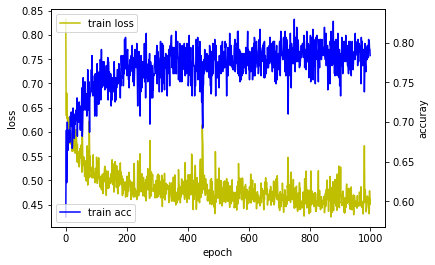

In [37]:
# Display acc, loss
if bi_class == 0:
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')

    acc_ax.plot(hist.history['categorical_accuracy'], 'b', label='train acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()
else:
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [38]:
predictions = full_model.predict(np.array(X_test).transpose([0,1,2,3]))

if bi_class==0:
    auc = roc_auc_score(Y_test, predictions, multi_class='raise')
    print('Multiclass Test AUC: ', auc)
else:
    auc = roc_auc_score(Y_test, predictions)
    print('Test AUC: ', auc)

Test AUC:  0.480952380952381


In [39]:
frequency = np.zeros(len(Y_test[0]))

for i in range(len(predictions)):
    frequency[np.argmax(predictions[i])] +=1
    
print(np.sum(Y_test, axis=0))
print(frequency)

[60.  7.]
[53. 14.]


In [40]:
if bi_class == 0:
    test_loss, test_acc, test_auc, test_F1 = full_model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)
else:
    test_loss, test_acc, test_auc = full_model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)

3/3 - 0s - loss: 0.6722 - accuracy: 0.7164 - auc: 0.7483

Accuracy: 0.7164179086685181
